# download MERGE_IR half-hourly images, a bigger equatorial box, before Irma 
## And then make movie frames of it

Restart stalled kernel and it will take up where it left off. Delete outputs to start over. 

In [1]:
import os 
import numpy as np
import xarray as xr
from datetime import date, timedelta, datetime
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.image import imread
import geocat.viz.util as gvutil
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from collections import deque
import matplotlib.patches as patches
from pathlib import Path
import json

In [36]:
class EyedropperAnnotator:
    def __init__(self):
        self.brown_events = deque()
        
    def add_events(self, centroids, sizes, current_time):
        """Add new events with sizes at current time"""
        for (lat, lon), size in zip(centroids, sizes):
            self.brown_events.append((lon, lat, current_time, size))
    
    def save_state(self, filepath):
        """Overwrite current state (for restart)"""
        def convert_event(event):
            return tuple(float(x) if isinstance(x, (np.floating, np.integer)) else x for x in event)
        
        state = {'brown_events': [convert_event(e) for e in self.brown_events]}
        with open(filepath, 'w') as f:
            json.dump(state, f)

    def append_history(self, filepath):
        """Append all events to growing file"""
        def convert_event(event):
            return tuple(float(x) if isinstance(x, (np.floating, np.integer)) else x for x in event)
        
        snapshot = {'brown_events': [convert_event(e) for e in self.brown_events]}
        with open(filepath, 'a') as f:
            f.write(json.dumps(snapshot) + '\n')

    @staticmethod
    def load_state(filepath):
        """Load state for restart, or create new if file doesn't exist"""
        if not Path(filepath).exists():
            return EyedropperAnnotator()
        with open(filepath, 'r') as f:
            state = json.load(f)
        annotator = EyedropperAnnotator()
        annotator.brown_events = deque(state['brown_events'])
        return annotator


    
    def plot_one_expanding_ring(self, ax, current_time, facecolor='orange'):
        """Plot expanding annuli with size-dependent opacity"""
        import matplotlib.patches as patches
        import cartopy.crs as ccrs
        
        to_remove = []
        for i, (lon, lat, birth_time, size) in enumerate(list(self.brown_events)):
            age = current_time - birth_time
            if age < 0:
                continue
                
            outer_r = age * 52 * 60 * 30 / 111111.1
            area = np.pi * (outer_r**2)
            alpha = min(0.8, size / max(area, 1))
            
            if alpha > 0.01:
                if outer_r > 0:
                    annulus = patches.Annulus((lon, lat), outer_r, width=outer_r/2, 
                                          facecolor=facecolor, alpha=alpha, 
                                          edgecolor='none', transform=ccrs.PlateCarree())
                    ax.add_patch(annulus)
            else:
                to_remove.append(i)
        
        for i in reversed(to_remove):
            del self.brown_events[i]


        
    def plot_expanding_ring_coriolis(self, ax, current_time, facecolor='orange', 
                                     spoke_color='red', n_spokes=12):
        """
        Plot expanding annuli with Coriolis-curved spokes.
        
        The spokes show counterclockwise rotation due to Coriolis force:
        - Each spoke curves from inner_r to outer_r
        - Older (larger radius) parts lag behind in azimuth
        - Mean azimuth rotates counterclockwise with age
        
        Args:
            ax: matplotlib axis
            current_time: current frame time
            facecolor: color of annulus
            spoke_color: color of Coriolis spokes
            n_spokes: number of spokes (default 12)
        """
        
        to_remove = []
        for i, (lon, lat, birth_time, size) in enumerate(list(self.brown_events)):
            age = current_time - birth_time
            if age < 0:
                continue
                
            outer_r = age * 52 * 60 * 30 / 111111.1  # degrees
            inner_r = outer_r / 2
            area = np.pi * (outer_r**2)
            alpha = min(0.8, size / max(area, 1))
            
            if alpha > 0.01:
                if outer_r > 0:
                    # Draw base annulus
                    annulus = patches.Annulus((lon, lat), outer_r, width=outer_r/2, 
                                          facecolor=facecolor, alpha=alpha, 
                                          edgecolor='none', transform=ccrs.PlateCarree())
                    ax.add_patch(annulus)
                    
                    # Draw Coriolis spokes
                    # Coriolis rotation: f = 2*Omega*sin(lat), integrated over time
                    # Approximate angular displacement: delta_theta ∝ age^2 * sin(lat)
                    lat_rad = np.radians(lat)
                    coriolis_factor = np.sin(lat_rad)  # Coriolis strength
                    
                    # Mean counterclockwise rotation increases with age
                    mean_rotation = coriolis_factor * age * 50  # degrees, tunable
                    
                    # Differential rotation: inner parts rotate more than outer
                    # (because they've experienced Coriolis longer)
                    rotation_gradient = coriolis_factor * age * 20  # degrees, tunable
                    
                    for spoke_idx in range(n_spokes):
                        # Base azimuth for this spoke
                        base_azimuth = spoke_idx * 360 / n_spokes
                        
                        # Create curved spoke from inner_r to outer_r
                        n_points = 20
                        radii = np.linspace(inner_r, outer_r, n_points)
                        
                        # Azimuth varies along spoke due to Coriolis
                        # Inner radius rotates more (older trajectory)
                        azimuths = base_azimuth + mean_rotation + rotation_gradient * (1 - radii/outer_r)
                        
                        # Convert to lon/lat offsets
                        x_offsets = radii * np.cos(np.radians(azimuths))
                        y_offsets = radii * np.sin(np.radians(azimuths))
                        
                        # Create curved path
                        spoke_lons = lon + x_offsets
                        spoke_lats = lat + y_offsets
                        
                        # Plot as curved line, with alpha 5x as great as the annulus for clarity
                        ax.plot(spoke_lons, spoke_lats, color=spoke_color, 
                               alpha=alpha, linewidth=1.5,     
                               transform=ccrs.PlateCarree())
            else:
                to_remove.append(i)
        
        for i in reversed(to_remove):
            del self.brown_events[i]
    
    # Add this method to your EyedropperAnnotator class
    

In [37]:
# WATERSHED get_feature_centroids_and_sizes(data_array, sigma=5, threshold=230, min_size=0)

from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import label, gaussian_filter

def get_feature_centroids_and_sizes(data_array, sigma=5, threshold=230, min_size=0):
    smimage = gaussian_filter(data_array.values, sigma=sigma)
    binary = smimage < threshold
    
    dist = distance_transform_edt(binary)
    labeled_array = watershed(-dist, mask=binary)
    
    lats = data_array.lat.values
    lons = data_array.lon.values
    
    centroids, sizes = [], []
    for fid in range(1, labeled_array.max() + 1):
        rows, cols = np.where(labeled_array == fid)
        size = len(rows)
        if size >= min_size:
            sizes.append(size)
            centroids.append((lats[int(rows.mean())], lons[int(cols.mean())]))
    
    return centroids, sizes

#from matplotlib.patches import Circle  # for a graphical test 
#centroids,sizes = get_feature_centroids_and_sizes(data_array, sigma=5, threshold=230)
#data_array.plot()
#for (lat, lon), size in zip(centroids, sizes):
#    plt.gca().add_patch(Circle((lon, lat), radius=np.sqrt(size/200/np.pi), fill=False, edgecolor='red'))

# okay let's make the frames of animation 

In [15]:
!mkdir /Users/bmapes//Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS_ann_spoke/

In [21]:
nc_folder = '~/Box/Sky_Symphony_Box/IRMA2017_weekprior/IRfiles/'
frame_folder = '/Users/bmapes//Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS_ann/'  # -16 to 16 latitude, annotated
frame_folder = '/Users/bmapes//Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS/'  # -16 to 16 latitude
frame_folder = '/Users/bmapes//Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS_ann_spoke/'  # -16 to 16 latitude

# had to mamba update netcdf4 but then it works 
ds = xr.open_mfdataset(nc_folder + '*.nc4', engine='netcdf4') 
ds.Tb 

<xarray.DataArray 'Tb' (time: 314, lat: 1100, lon: 1374)> Size: 2GB
dask.array<concatenate, shape=(314, 1100, 1374), dtype=float32, chunksize=(2, 1100, 1374), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 5kB 0.01819 0.05457 0.09094 ... 49.89 49.93 49.97
  * lat      (lat) float32 4kB -19.99 -19.96 -19.92 -19.88 ... 19.92 19.96 19.99
  * time     (time) datetime64[ns] 3kB 2017-08-13T05:00:00.000013312 ... 2017...
Attributes:
    units:          K
    standard_name:  brightness_temperature

In [22]:
# panzoom function Interpolates "extent" as a function of frame_count)

# Define interpolation function with optional time warping
def panzoom(frame_count, frame_start, frames_total, easing=None):
    if frame_count <= frame_start:
        return extent
    if frame_count >= frame_end:
        return extent2
    # Normalize t to [0, 1]
    t = (frame_count - frame_start) / frames_total
    # Optionally apply non-linear time mapping
    if easing:
        t = easing(t)
    return [np.interp(t, [0, 1], [e1, e2]) for e1, e2 in zip(extent, extent2)]

In [23]:
# UPDATED create_masked_cmap function: a time dependent colormap with black masked range of Tb 
# time it is its parameter, retreating from the cold end except the orange is there too 

from matplotlib.colors import LinearSegmentedColormap, to_rgba
import numpy as np

def create_masked_cmap(it, vmin=190, vmax=340, verbose=False, 
                       mask_bot=220, mask_top=305, blackrate=1.0):
    """
    Create a colormap with a time-dependent retreating black mask.
    
    Args:
        it: time parameter (frame number or time index)
        vmin, vmax: data value range
        verbose: print mask range info
        mask_bot: bottom of mask band (retreats with time)
        mask_top: top of mask band (fixed)
        blackrate: how fast the mask retreats (Tb units per time step)
    
    Returns:
        cmap: LinearSegmentedColormap with masked band
    """
    
    # Define original colormap
    color_points = [
        (190, "#dc05ef", 1.0),   # magenta 
        (222, "#0589ef", 1.0),   # blue
        (240, "#00ffff", 1.0),   # cyan
        (250, "#716f6f", 1.0),   # darker gray 
        (270, "#c5c6c6", 1.0),   # light-mid gray
        (280, "#ffffff", 0.9),   # white semitrans
        (290, "#ffffff", 0.6),   # white point surface
        (300, "#ffffff", 0.1),   # SST point water
        (305, "#ffffff", 0.4),   # transparent white cool surfaces
        (310, "#ff8000", 1.0),   # HOT surface orange
        (340, "#000000", 1.0)    # HOTHOT surface black
    ]
    
    # Create base colormap first
    cmap_colors = [((v - vmin) / (vmax - vmin), to_rgba(c, a)) for v, c, a in color_points]
    base_cmap = LinearSegmentedColormap.from_list("base_custom", cmap_colors)
    
    # Calculate mask band: [mask_bot + it*blackrate, mask_top]
    mask_lower = mask_bot + it * blackrate
    mask_upper = mask_top
    mask_lower_norm = (mask_lower - vmin) / (vmax - vmin)
    mask_upper_norm = (mask_upper - vmin) / (vmax - vmin)
    
    if verbose:
        print('mask range: ', mask_lower, mask_upper)
    
    # Sample the interpolated colormap densely, then mask it smoothly
    n_samples = 256
    pos_array = np.linspace(0, 1, n_samples)
    rgba_array = base_cmap(pos_array)
    
    # Set masked band to black with full opacity
    mask_idx = (pos_array >= mask_lower_norm) & (pos_array <= mask_upper_norm)
    rgba_array[mask_idx] = [0, 0, 0, 1.0]
    
    # Create new colormap from the masked array
    return LinearSegmentedColormap.from_list("masked_custom", 
                                             list(zip(pos_array, rgba_array)))

# Usage:
# cmap = create_masked_cmap(it=10, blackrate=1.0, verbose=True)
# colored = cmap(normalized_data)

In [24]:
# Read in big Blue Marble image 
# --- Place this code BEFORE your 1000-frame loop (Load ONCE) ---

# Disable the decompression bomb check
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

# --- Configuration (MUST match your image and desired georeference) ---
STATIC_MAP_FILE = '/Users/bmapes/Box/Sky_Symphony_Box/BlueMarble.200408.3x21600x10800.jpg' 
FULL_WORLD_EXTENT = [-180, 180, -90, 90] 
try:
    # Load the single satellite image file ONLY ONCE
    BASE_IMAGE_DATA = imread(STATIC_MAP_FILE)
except FileNotFoundError:
    raise FileNotFoundError(f"Error: Static map file '{STATIC_MAP_FILE}' not found. '+\
    'Please download a high-res Blue Marble image and save it to this name.")

Saved /Users/bmapes//Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS_ann_spoke/00000000.png
Tb at 2017-08-13T05:00:00.000013312
Saved /Users/bmapes//Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS_ann_spoke/00000001.png
Tb at 2017-08-13T05:30:00.000026880
Saved /Users/bmapes//Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS_ann_spoke/00000002.png
Tb at 2017-08-13T06:00:00.000000000
Saved /Users/bmapes//Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS_ann_spoke/00000003.png
Tb at 2017-08-13T06:30:00.000013312
Saved /Users/bmapes//Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS_ann_spoke/00000004.png
Tb at 2017-08-13T07:00:00.000026880
Saved /Users/bmapes//Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS_ann_spoke/00000005.png
Tb at 2017-08-13T07:30:00.000000000
Saved /Users/bmapes//Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS_ann_spoke/00000006.png
Tb at 2017-08-13T08:00:00.000013312
Saved /Users/bmapes//Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS_ann_spoke/0

OSError: [Errno 28] No space left on device: 'annotator_state.pkl'

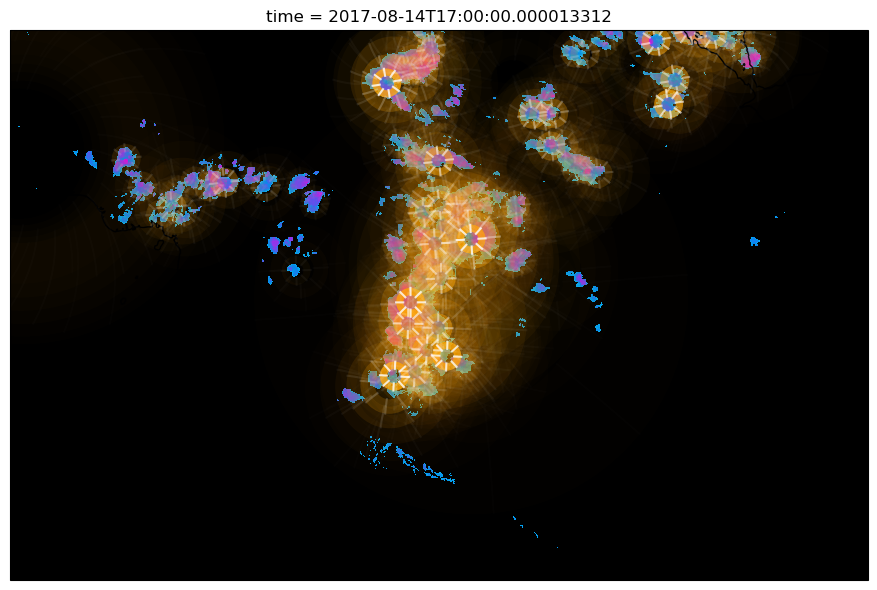

In [39]:
# Loop over times, making frames in the named folder frame_folder 

vmin = 190; vmax=340 # as in Irma movie frames
dpi = 150

mask_bottom = 200  # 50th frame is wonderful at 250 
blackrate = 0.4 # mask reveal rate, K per frame. 1 starts grays at frame 50/313, maybe 0.3 so ~half is abstract blue tops 

frame_start = 250 # Start pan-zooming at frame 250

# Initialize annotator, loading past state if this is a restart
annotator = EyedropperAnnotator.load_state('annotator_state.pkl')
# annotator = EyedropperAnnotator( )  


# Define the end extent of this frame sequence, for panzoom function 
ds2 = xr.open_dataset("/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/ncfiles/time000.nc")
extent2 = [ min(ds2.lon), max(ds2.lon),
            min(ds2.lat), max(ds2.lat) ]


# Loop over the times, making the frames
for frame_count in range(len(ds.time)): 
    
    ######## Plotting code if file does not exist (for restart after kernel crashes) 
    out_file = frame_folder+ f"{frame_count:08d}.png"
    if not os.path.exists(out_file):

        # On restart:
        annotator = EyedropperAnnotator.load_state('annotator_state.pkl')

        Tb = ds.Tb.isel(time = frame_count).interpolate_na(dim="lon", method="linear", max_gap=2)

# Convective Events 
        centroids,sizes = get_feature_centroids_and_sizes(Tb, sigma=7, threshold=230, 
                                                      min_size=20)

    # Define extent from the data, and extent_now as a function of frame_count
    # interpolating toward the first frame of Irma... 
        extent = [ min(ds.lon), max(ds.lon), -16, 16 ]
                   # min(ds.lat), max(ds.lat) ] # aspect ratio was wrong in data, gotta match movie_IRMA

    #### Time dependent effects
    # Start zooming at frame 300
        # frame_start = 300    # set above 
        frame_end = len(ds.time) - 1  # assuming 0-based indexing
        frames_total = frame_end - frame_start
        extent_now = panzoom(frame_count, frame_start, frames_total, easing=False)
    
    # Fade from black effect: unveiling from coldest to warmest, but all with hot orange daytime showing
        cmap = create_masked_cmap(it=frame_count, vmin=vmin, vmax=vmax, verbose=False, 
                                  mask_bot = mask_bottom, mask_top = 310, blackrate=blackrate) 
                                                  # blackrate in K per timestep (1/2 hour)
        
            
    # Plot data on top of blue marble image, there is some transparency 
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Extent sets the area covered.
    # pan+zoom effect has extent transition from full to Irma-begin coordinates. 
        ax.set_extent(extent_now, crs=ccrs.PlateCarree())
        
    # Background image: cheap stock image? Naw, blue marble for August
        #ax.stock_img()  # low-res natural Earth background
        ax.imshow(BASE_IMAGE_DATA,      
          origin='upper', transform=ccrs.PlateCarree(), extent=FULL_WORLD_EXTENT)
    
        ax.coastlines()
            #ax.coastlines(resolution='50m', color='white', linewidth=0.5, zorder=3)
            #ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.set_title(f"Tb at {Tb.time.values}", fontsize=12)
    
    # image of the data   
        Tb.plot.imshow(
            ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin,vmax=vmax,\
            add_colorbar=False, #cbar_kwargs={'label': 'Brightness Temperature [K]'}
        )
        plt.tight_layout()
        
# Add eyedropper annotations    
        # In your loop:
        annotator.add_events(centroids, (np.array(sizes)/1000.).tolist(), frame_count)
#        annotator.plot_one_expanding_ring(ax, frame_count, facecolor='orange')
        annotator.plot_expanding_ring_coriolis(ax, frame_count, 
                                       facecolor='orange', 
                                       spoke_color='white',
                                       n_spokes=8)

        annotator.save_state('annotator_state.pkl')
        annotator.append_history('annotator_history.jsonl')
       
# Cover annotations with zorder=10, near the souce where they are too hokey 
        Tb.where(Tb < 230).plot.imshow(ax=ax, add_colorbar=False, cmap=cmap, vmin=vmin,vmax=vmax, zorder=10)
        
        plt.savefig(out_file, dpi=dpi)
        plt.close()
        print(f"Saved {out_file}")
        print(f"Tb at {Tb.time.values}")

    

In [11]:
# Crop them all 

from pathlib import Path; from PIL import Image
SOURCE = Path('/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS/')
OUTPUT = Path('/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/frames16NS_crop')
OUTPUT.mkdir(exist_ok=True) 

CROP = (210, 70, 1290, 850)
for f in SOURCE.glob('*.png'): Image.open(f).crop(CROP).save(OUTPUT / f.name)

KeyboardInterrupt: 

In [12]:
# 4. Create simple video using ffmpeg
from subprocess import run

ffmpeg_cmd = [
    "ffmpeg", "-y", "-framerate", "6",
    "-i", str(OUTPUT / "%08d.png"),
    "-c:v", "libx264", "-pix_fmt", "yuv420p",
    "/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Weekprior_blackfade0p4_panzoom_annot.mp4"
]

print("Creating video...")
run(ffmpeg_cmd)
print(f"✅ Video saved")

Creating video...


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with clang version 18.1.8
  configuration: --prefix=/Users/bmapes/.local/share/mamba/envs/hk25 --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1746479731466/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libmp3lame --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zli

✅ Video saved


[out#0/mp4 @ 0x6000005d0000] video:29151KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.015343%
frame=  314 fps=2.1 q=-1.0 Lsize=   29155KiB time=00:00:52.00 bitrate=4593.1kbits/s speed=0.346x    
[libx264 @ 0x15a7046d0] frame I:39    Avg QP:16.78  size:135363
[libx264 @ 0x15a7046d0] frame P:110   Avg QP:21.58  size: 89231
[libx264 @ 0x15a7046d0] frame B:165   Avg QP:22.64  size: 89425
[libx264 @ 0x15a7046d0] consecutive B-frames: 27.7%  4.5%  6.7% 61.1%
[libx264 @ 0x15a7046d0] mb I  I16..4: 15.7% 43.4% 40.9%
[libx264 @ 0x15a7046d0] mb P  I16..4:  1.9% 23.8% 26.4%  P16..4:  7.4%  4.4%  2.8%  0.0%  0.0%    skip:33.2%
[libx264 @ 0x15a7046d0] mb B  I16..4:  1.7%  8.5% 21.2%  B16..8: 12.0%  8.7%  5.9%  direct: 3.5%  skip:38.6%  L0:44.6% L1:37.8% BI:17.6%
[libx264 @ 0x15a7046d0] 8x8 transform intra:38.5% inter:38.5%
[libx264 @ 0x15a7046d0] coded y,uvDC,uvAC intra: 65.0% 63.1% 45.4% inter: 20.9% 21.3% 11.9%
[libx264 @ 0x15a7046d0] i16 v,h,dc,p: 67% 15% 